<a href="https://colab.research.google.com/github/jcval94/Actuarial-Functions/blob/master/SP500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


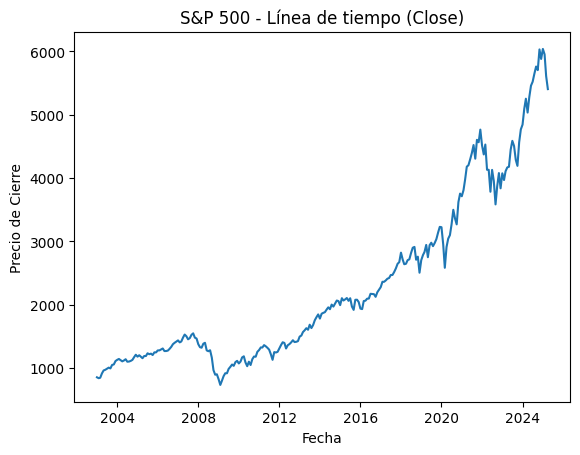

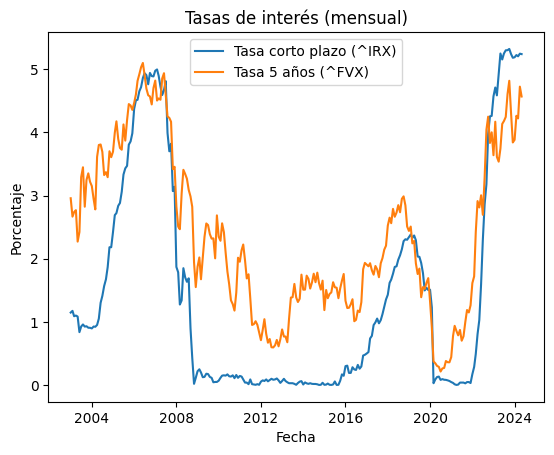

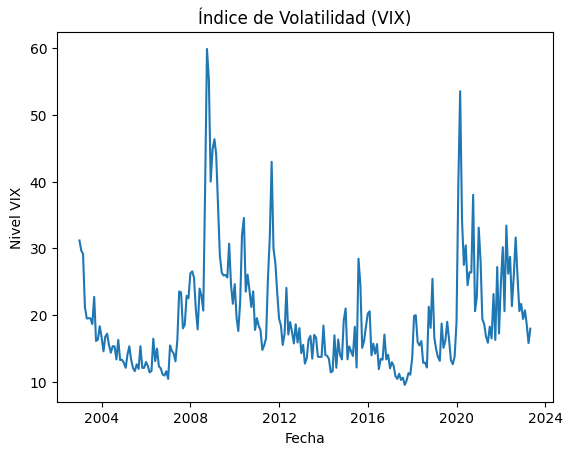

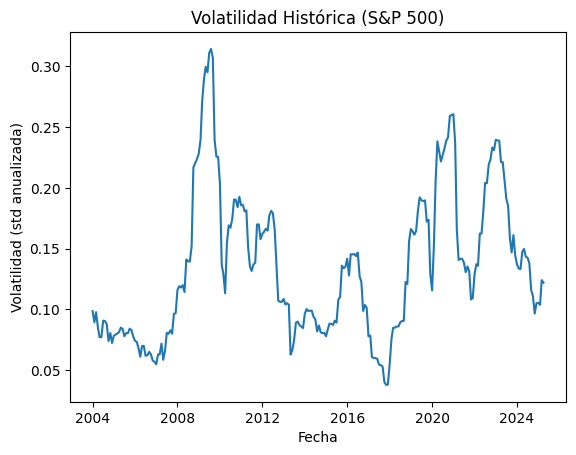

<ipython-input-6-a21035c31851>:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_close = sp500['Close'].asfreq('M')  # Nos aseguramos de tener frecuencia mensual fija
<ipython-input-6-a21035c31851>:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_close = data_close.fillna(method='ffill')  # Por si hay huecos
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
<ipython-input-6-a21035c31851>:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_train_date + pd.offsets.MonthBegin(),


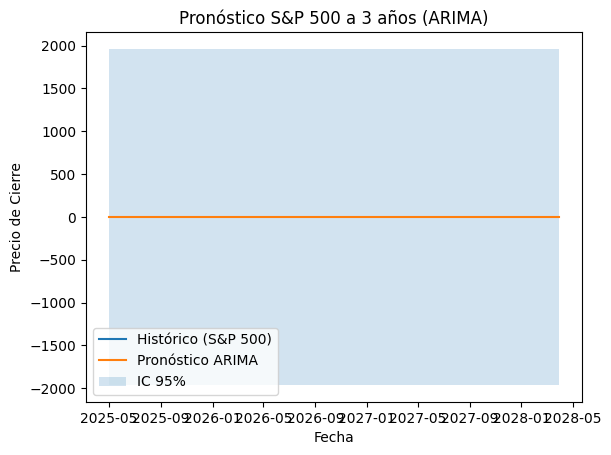

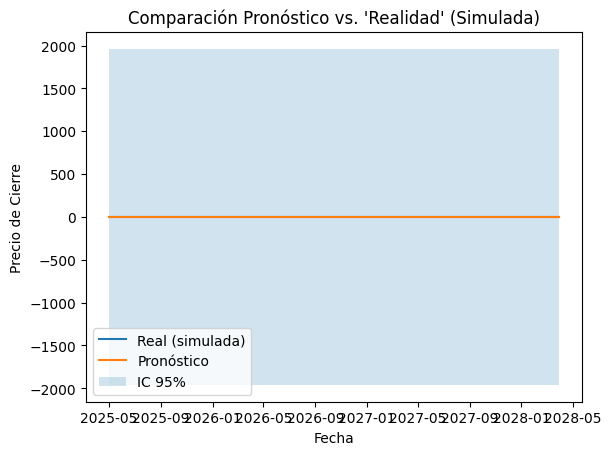

¡Proceso finalizado!


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

###################################
# 1. DESCARGA DE DATOS
###################################

start_date = "2003-01-01"
end_date = "2025-04-15"  # Simulamos datos hasta la fecha actual

# --- S&P 500 ---
sp500_raw = yf.download("^GSPC", start=start_date, end=end_date, interval='1mo', group_by='ticker')
sp500 = sp500_raw['^GSPC'].copy()
sp500.dropna(inplace=True)  # Eliminamos filas vacías

# --- Tasas de interés (usando ^IRX y ^FVX como ejemplo) ---
# ^IRX = 13 Week Treasury Bill => Tasa a ~3 meses (puede tomarse como referencia de interés "corto plazo")
# ^FVX = 5 Year Treasury Note Yield => Tasa a 5 años
irx_raw = yf.download("^IRX", start=start_date, end=end_date, interval='1mo', group_by='ticker')
irx = irx_raw['^IRX'].copy()
irx.dropna(inplace=True)

fvx_raw = yf.download("^FVX", start=start_date, end=end_date, interval='1mo', group_by='ticker')
fvx = fvx_raw['^FVX'].copy()
fvx.dropna(inplace=True)

# --- Volatilidad (VIX) ---
vix_raw = yf.download("^VIX", start=start_date, end=end_date, interval='1mo', group_by='ticker')
vix = vix_raw['^VIX'].copy()
vix.dropna(inplace=True)

###################################
# 2. GRÁFICAS DE REFERENCIA
###################################

# 2.1. Línea de tiempo del S&P 500 (precio de cierre)
plt.figure()
plt.plot(sp500.index, sp500['Close'])
plt.title("S&P 500 - Línea de tiempo (Close)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.show()

# 2.2. Tasas de interés: corto plazo (^IRX) y 5 años (^FVX)
plt.figure()
plt.plot(irx.index, irx['Close'], label="Tasa corto plazo (^IRX)")
plt.plot(fvx.index, fvx['Close'], label="Tasa 5 años (^FVX)")
plt.title("Tasas de interés (mensual)")
plt.xlabel("Fecha")
plt.ylabel("Porcentaje")
plt.legend()
plt.show()

# 2.3. Volatilidad: VIX
plt.figure()
plt.plot(vix.index, vix['Close'])
plt.title("Índice de Volatilidad (VIX)")
plt.xlabel("Fecha")
plt.ylabel("Nivel VIX")
plt.show()

###################################
# 3. CÁLCULO Y GRÁFICA DE LA VOLATILIDAD REALIZADA (OPCIONAL)
###################################
# Como ejemplo, calculamos la volatilidad histórica (realizada) del S&P 500
# a partir de la desviación estándar de los rendimientos logarítmicos mensuales.

sp500['Returns'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500['Volatilidad'] = sp500['Returns'].rolling(window=12).std() * np.sqrt(12)  # Anualizada

plt.figure()
plt.plot(sp500.index, sp500['Volatilidad'])
plt.title("Volatilidad Histórica (S&P 500)")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad (std anualizada)")
plt.show()

###################################
# 4. PRONÓSTICO PARA LOS PRÓXIMOS 3 AÑOS
###################################
# Ejemplo sencillo con ARIMA en base a la serie mensual de Cierre.

# 4.1. Preparamos la serie temporal
data_close = sp500['Close'].asfreq('M')  # Nos aseguramos de tener frecuencia mensual fija
data_close = data_close.fillna(method='ffill')  # Por si hay huecos

# 4.2. Entrenamiento hasta 2025-04-15, pronóstico hasta 2028-04-15 (3 años ~ 36 meses)
#      NOTA: Esto es meramente ilustrativo; no hay datos reales futuros.
train_end_date = datetime.datetime(2025, 4, 15)
forecast_horizon_months = 36  # 3 años

# Aseguramos que la serie de entrenamiento sea hasta la fecha disponible (~2025-04)
train_data = data_close[data_close.index <= pd.to_datetime(train_end_date)]
# Ajustamos un modelo ARIMA (parámetros de ejemplo)
model = ARIMA(train_data, order=(2,1,2))
results = model.fit()

# Generamos pronóstico a 36 meses
forecast_res = results.get_forecast(steps=forecast_horizon_months)
forecast_mean = forecast_res.predicted_mean
confidence_int = forecast_res.conf_int()

# Construimos un índice de tiempo para el pronóstico
last_train_date = train_data.index[-1]
forecast_dates = pd.date_range(start=last_train_date + pd.offsets.MonthBegin(),
                               periods=forecast_horizon_months, freq='M')

# DataFrame con los resultados del pronóstico
forecast_df = pd.DataFrame({
    "Forecast": forecast_mean.values,
    "Lower CI": confidence_int.iloc[:, 0].values,
    "Upper CI": confidence_int.iloc[:, 1].values
}, index=forecast_dates)

# 4.3. Gráfica del pronóstico
plt.figure()
plt.plot(data_close.index, data_close, label="Histórico (S&P 500)")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Pronóstico ARIMA")
plt.fill_between(forecast_df.index,
                 forecast_df["Lower CI"],
                 forecast_df["Upper CI"],
                 alpha=0.2, label="IC 95%")
plt.title("Pronóstico S&P 500 a 3 años (ARIMA)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.show()

###################################
# 5. COMPARACIÓN FICTICIA CON LA “REALIDAD”
###################################
# Supongamos que ya estamos en 2025-04-15 y tenemos datos hasta 2028-04-15.
# Como no existe ese dato real, hacemos una simulación.
# En un caso real, aquí cargaríamos la data real del S&P 500 para el período 2025-04-15 a 2028-04-15
# y la compararíamos con "forecast_df".

# EJEMPLO: Creamos una serie simulada con algo de crecimiento y volatilidad
rng_sim = np.random.default_rng(42)
simulated_values = forecast_df["Forecast"] * (1 + rng_sim.normal(0, 0.01, size=len(forecast_df)))

simulated_real = pd.Series(simulated_values, index=forecast_df.index)

# Gráfica: pronóstico vs "realidad" simulada
plt.figure()
plt.plot(simulated_real.index, simulated_real, label="Real (simulada)")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Pronóstico")
plt.fill_between(forecast_df.index,
                 forecast_df["Lower CI"],
                 forecast_df["Upper CI"],
                 alpha=0.2,
                 label="IC 95%")
plt.title("Comparación Pronóstico vs. 'Realidad' (Simulada)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.show()

print("¡Proceso finalizado!")


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# auto_arima para selección de parámetros ARIMA
from pmdarima.arima import auto_arima

###################################
# 1. DESCARGA Y PREPARACIÓN DE DATOS
###################################
start_date = "2000-01-01"
end_date   = "2023-12-31"  # Entrenamos el modelo con datos hasta finales de 2023

# Descargamos datos mensuales del S&P 500 (^GSPC)
sp500_data_raw = yf.download("^GSPC", start=start_date, end=end_date, interval='1mo', group_by='ticker')
sp500_data = sp500_data_raw['^GSPC'].copy()

# Nos quedamos con la columna Close (precio de cierre)
sp500_data = sp500_data[['Close']].dropna()

# Convertimos a frecuencia mensual uniforme, forward-fill para huecos
sp500_data = sp500_data.asfreq('M')
sp500_data = sp500_data.fillna(method='ffill')

# Por conveniencia, renombramos la columna
sp500_data.columns = ["Close"]

###################################
# 2. DIVISIÓN EN TRAIN Y TEST
###################################
# Suponemos que vamos a usar datos hasta 2020 inclusive para entrenar (train),
# y usaremos 2021-2023 como periodo de prueba (test).
train_end = datetime.datetime(2020, 12, 31)

train_data = sp500_data.loc[:train_end]
test_data  = sp500_data.loc[train_end + pd.offsets.MonthEnd():]

# Verificamos las últimas fechas de train y las primeras de test
print("Última fecha train:", train_data.index[-1])
print("Primera fecha test:", test_data.index[0])

###################################
# 3. SELECCIÓN AUTOMÁTICA DE MODELO ARIMA (auto_arima)
###################################
# auto_arima buscará parámetros (p,d,q)(P,D,Q)m que minimicen un criterio (AIC, BIC...)
# Ajustamos algunos límites de búsqueda. Ajustar según quieras más exhaustividad.
model = auto_arima(
    train_data['Close'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=False,        # Desactivamos SARIMA (no esperamos estacionalidad clara en monthly)
    trace=True,            # Muestra el proceso de búsqueda
    stepwise=True,         # Búsqueda escalonada más eficiente
    information_criterion='aic'
)

print("\n--- Mejor modelo ARIMA encontrado ---")
print(model.summary())

###################################
# 4. EVALUACIÓN EN CONJUNTO DE PRUEBA (2021-2023)
###################################
# Hacemos el pronóstico en el periodo de test y medimos error
n_test = len(test_data)  # número de meses en test
fitted_model = model  # auto_arima ya se encuentra ajustado
forecast_test = fitted_model.predict(n_periods=n_test)  # array con pronóstico

# Creamos un DataFrame alineado a las fechas de test
forecast_index = test_data.index
predictions_df = pd.DataFrame({
    'Predicted': forecast_test
}, index=forecast_index)

# Calcular error (por ejemplo RMSE, MAPE)
actual_values = test_data['Close']
rmse = np.sqrt(((predictions_df['Predicted'] - actual_values) ** 2).mean())
mape = np.mean(np.abs((actual_values - predictions_df['Predicted']) / actual_values)) * 100

print(f"\nRMSE en test (2021-2023): {rmse:.2f}")
print(f"MAPE en test (2021-2023): {mape:.2f}%")

###################################
# 5. PRONÓSTICO A 3 AÑOS (2024-2026)
###################################
# Reajustamos (o reentrenamos) el modelo con TODOS los datos hasta 2023-12
final_model = auto_arima(
    sp500_data['Close'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=False,
    trace=False,
    stepwise=True,
    information_criterion='aic'
)

# Predecimos 36 meses (~3 años) a partir de 2024-01
n_months_forecast = 36
final_forecast = final_model.predict(n_periods=n_months_forecast)

# Construimos rango de fechas para el pronóstico: 2024-01 a 2026-12
last_date = sp500_data.index[-1]  # 2023-12-31 (freq=M)
forecast_dates = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=n_months_forecast,
    freq='M'
)

forecast_df = pd.DataFrame({
    'Forecast': final_forecast
}, index=forecast_dates)

###################################
# 6. GRÁFICAS
###################################
plt.figure(figsize=(10, 6))

# (A) Toda la serie histórica 2000-2023
plt.plot(sp500_data.index, sp500_data['Close'], label='Histórico (2000-2023)', color='blue')

# (B) Predicción en el periodo de prueba (2021-2023) - para ver cómo se ajustó
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicción (Test 2021-2023)', color='orange')

# (C) Pronóstico 2024-2026
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Pronóstico (2024-2026)', color='red')

plt.title("Pronóstico S&P 500 a 3 años (con auto_arima y datos históricos hasta 2023)")
plt.xlabel("Fecha")
plt.ylabel("Índice S&P 500 (Close)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. Descargar datos diarios y re-muestrear a datos quincenales.
start_date = '2000-01-01'
end_date = '2023-12-31'
data = yf.download("^GSPC", start=start_date, end=end_date, interval='1d')

# Seleccionamos la columna 'Close' y eliminamos datos faltantes
df_daily = data[['Close']].dropna()

# Resample: se utiliza la frecuencia "2W" (cada 2 semanas),
# tomando el último valor disponible en cada período.
df_quincenal = df_daily.resample('2W').last()

# Visualizar los primeros datos quincenales
print("Datos quincenales:")
print(df_quincenal.head())

# 2. Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_quincenal)

# 3. Preparar el dataset de entrenamiento mediante ventanas deslizantes.
def create_dataset(dataset, time_step=10):
    """
    Crea conjuntos X e y usando una ventana de 'time_step' períodos para predecir el siguiente valor.
    """
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 10  # número de períodos quincenales a utilizar para la predicción
X, y = create_dataset(scaled_data, time_step)

# Reshape de X al formato requerido [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# 4. División en entrenamiento y prueba (por ejemplo, 80% de los datos para entrenar)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Construcción del modelo LSTM
model = Sequential()
# Primera capa LSTM con 50 unidades; return_sequences=True para pasar la secuencia a la siguiente capa
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# Segunda capa LSTM
model.add(LSTM(50, return_sequences=False))
# Capa intermedia Dense para mayor capacidad
model.add(Dense(25))
# Capa de salida para predecir un valor
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()

# 6. Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# 7. Predicción iterativa: se utilizarán los últimos 'time_step' valores para predecir el siguiente
#    y se itera para generar varios períodos quincenales.
n_forecast = 12  # Número de períodos a predecir (por ejemplo, 12 períodos = 24 semanas aprox.)
# Se toma la última ventana de la serie escalada
input_seq = scaled_data[-time_step:]
input_seq = input_seq.reshape(1, time_step, 1)



In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Scikit-learn para cross-validation y Random Forest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# 1) Descargar S&P 500 (datos diarios)
start_date = "2000-01-01"
end_date   = "2025-04-15"  # o la fecha actual aproximada
df_daily = yf.download("^GSPC", start=start_date, end=end_date, interval='1d')

# 2) Resampleo a quincenal (2 semanas)
# Tomaremos el último valor de cada ventana de 2 semanas como la "Close" representativa
df_2w = df_daily.resample('2W').last()

# Aseguramos que no haya nulos
df_2w = df_2w[['Close']].dropna()

# ------------------------------------------------
# 3) Construir variables adicionales
# ------------------------------------------------

# Ordenamos por fecha ascendente por seguridad
df_2w.sort_index(inplace=True)

# Preparamos el DataFrame de features
df_feat = df_2w.copy()

# Función auxiliar para rolling en quincenal
window = 3  # calcularemos estadísticos en los últimos 3 periodos quincenales
roll_data = df_feat['Close'].rolling(window=window, min_periods=1)

# Máximo de los últimos 3 periodos
df_feat['max_3'] = roll_data.max()

# Mínimo de los últimos 3 periodos
df_feat['min_3'] = roll_data.min()

# Mediana de los últimos 3 periodos
df_feat['median_3'] = roll_data.median()

# Percentiles 5, 25, 75, 95 de los últimos 3 periodos
df_feat['p5_3']  = roll_data.quantile(0.05)
df_feat['p25_3'] = roll_data.quantile(0.25)
df_feat['p75_3'] = roll_data.quantile(0.75)
df_feat['p95_3'] = roll_data.quantile(0.95)

# Medias móviles de los últimos 2, 3 y 4 periodos
df_feat['ma_2'] = df_feat['Close'].rolling(window=2, min_periods=1).mean()
df_feat['ma_3'] = df_feat['Close'].rolling(window=3, min_periods=1).mean()
df_feat['ma_4'] = df_feat['Close'].rolling(window=4, min_periods=1).mean()

# Eliminamos filas iniciales que puedan tener datos incompletos
df_feat.dropna(inplace=True)

# df_feat ahora contiene 'Close' y las nuevas features
print(df_feat.head())


split_date = datetime.datetime(2024, 1, 1)

df_train = df_feat.loc[df_feat.index < split_date]
df_test  = df_feat.loc[df_feat.index >= split_date]

print("Train data range:", df_train.index.min(), "->", df_train.index.max())
print("Test data range:", df_test.index.min(), "->", df_test.index.max())


from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, look_back=3):
    """
    data: DataFrame con columnas:
          - 'Close' (la que queremos predecir)
          - otras features
    look_back: nº de pasos atrás para la LSTM
    """
    X, y = [], []

    # Convertimos a numpy para indexing
    data_np = data.values
    # Indices de columnas
    # close_idx = list(data.columns).index('Close') # Original line causing error
    close_idx = 0  # Close is the first column after scaling, so its index is 0

    for i in range(len(data_np) - look_back):
        seq_x = data_np[i:i+look_back]  # Ventana con features
        seq_y = data_np[i+look_back, close_idx]  # Valor de 'Close' en el siguiente instante
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

# Preparamos un escalador para normalizar las features y la variable Close
scaler = MinMaxScaler(feature_range=(0,1))

# Ajustamos el scaler con los datos de ENTRENAMIENTO (df_train) solamente
scaler.fit(df_train)

# Escalamos datos de train
df_train_scaled = pd.DataFrame(scaler.transform(df_train),
                               columns=df_train.columns,
                               index=df_train.index)

# Creamos secuencias de train
look_back = 3
X_train_all, y_train_all = create_sequences(df_train_scaled, look_back=look_back)

# Estructura para cross-validation
tscv = TimeSeriesSplit(n_splits=3)  # Ajusta n_splits según prefieras

fold = 1
for train_idx, val_idx in tscv.split(X_train_all):
    print(f"Fold {fold}: Train size={len(train_idx)}, Val size={len(val_idx)}")

    X_train_cv, y_train_cv = X_train_all[train_idx], y_train_all[train_idx]
    X_val_cv,   y_val_cv   = X_train_all[val_idx],   y_train_all[val_idx]

    # --- Construir la LSTM ---
    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(look_back, df_train_scaled.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Early stopping
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenar
    history = model.fit(X_train_cv, y_train_cv,
                        validation_data=(X_val_cv, y_val_cv),
                        epochs=50, batch_size=16,
                        callbacks=[es],
                        verbose=0)

    val_loss = history.history['val_loss'][-1]
    print(f"  -> Fold {fold} final val_loss: {val_loss:.6f}")

    fold += 1

print("Cross-validation finalizada.")


# 6.1. Entrenar con todo el conjunto de entrenamiento
X_train_final, y_train_final = X_train_all, y_train_all  # ya escalados

model_final_lstm = Sequential()
model_final_lstm.add(LSTM(64, activation='tanh', return_sequences=False,
                          input_shape=(look_back, df_train_scaled.shape[1])))
model_final_lstm.add(Dense(1))
model_final_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

es_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_final = model_final_lstm.fit(X_train_final, y_train_final,
                                     validation_split=0.1,
                                     epochs=50, batch_size=16,
                                     callbacks=[es_final],
                                     verbose=1)

# Para el Random Forest, podríamos aplanar la secuencia (look_back, n_features) a un solo vector.
# Ejemplo:
X_train_rf = X_train_final.reshape(X_train_final.shape[0], -1)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_final)


# Escalamos test
df_test_scaled = pd.DataFrame(scaler.transform(df_test),
                              columns=df_test.columns,
                              index=df_test.index)

X_test, y_test = create_sequences(df_test_scaled, look_back=look_back)

# Mismas dimensiones para RF
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Predicción LSTM
y_pred_lstm_scaled = model_final_lstm.predict(X_test)

# Predicción Random Forest
y_pred_rf_scaled = rf_model.predict(X_test_rf)

# 'y_test' está en escala [0,1]. Lo convertimos a valores originales
# Creamos un df temporal para hacer "inverse_transform"
# Respetando la posición de la columna 'Close'
temp_test = df_test_scaled.copy()  # DataFrame escalado
close_idx = 0
# Reconstruiremos vectores con la forma original para inverse_transform
# y_pred_lstm_scaled, y_test => (N, )
y_pred_lstm_original = []
y_pred_rf_original = []
y_test_original = []

for i in range(len(y_pred_lstm_scaled)):
    # Creamos una fila dummy
    row_dummy = np.zeros(temp_test.shape[1])

    # Asignamos la predicción a la posición de 'Close'
    row_dummy[close_idx] = y_pred_lstm_scaled[i]
    # Invertimos
    row_inversed = scaler.inverse_transform([row_dummy])[0]
    y_pred_lstm_original.append(row_inversed[close_idx])

    # Para RF
    row_dummy_rf = np.zeros(temp_test.shape[1])
    row_dummy_rf[close_idx] = y_pred_rf_scaled[i]
    row_inversed_rf = scaler.inverse_transform([row_dummy_rf])[0]
    y_pred_rf_original.append(row_inversed_rf[close_idx])

    # El valor real
    row_dummy_true = np.zeros(temp_test.shape[1])
    row_dummy_true[close_idx] = y_test[i]
    row_inversed_true = scaler.inverse_transform([row_dummy_true])[0]
    y_test_original.append(row_inversed_true[close_idx])

# Convertir a arrays
y_pred_lstm_original = np.array(y_pred_lstm_original)
y_pred_rf_original   = np.array(y_pred_rf_original)
y_test_original      = np.array(y_test_original)

# Indices para estas predicciones (los últimos len(y_test) quincenales del 2024-2025)
dates_test = df_test.index[look_back:]  # se desplaza 'look_back' filas


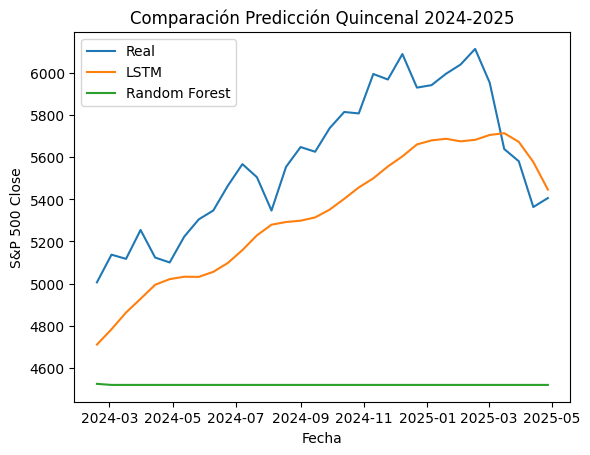

In [62]:
# Reconstruimos la serie real y la recortamos al mismo rango
df_real_test = df_test.iloc[look_back:].copy()  # quita las primeras 'look_back' filas
close_real   = df_real_test['Close'].values  # valores reales

plt.figure()
plt.plot(dates_test, close_real, label="Real")
plt.plot(dates_test, y_pred_lstm_original, label="LSTM")
plt.plot(dates_test, y_pred_rf_original, label="Random Forest")

plt.title("Comparación Predicción Quincenal 2024-2025")
plt.xlabel("Fecha")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.show()


# Nuevo intento

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0421
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8735e-04
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4746e-04
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5890e-04
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3602e-04
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8815e-04
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3808e-04
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5569e-04
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6028e-04
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4721e-04
Epoch 14/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9

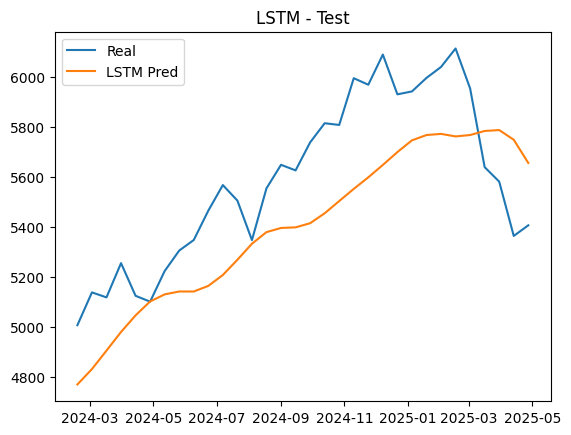

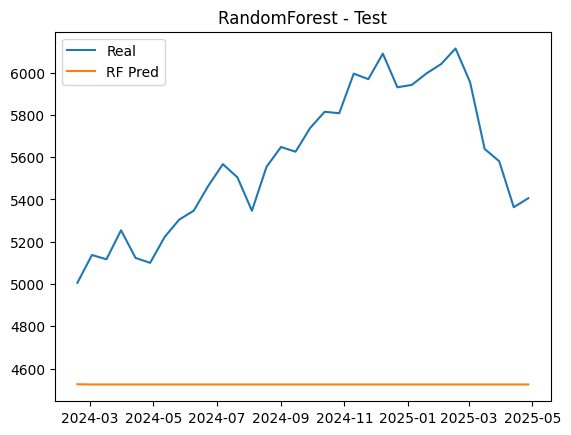


=== Ejemplo de predicción de la siguiente observación con un nuevo valor ===


<ipython-input-63-430bebfd4ffb>:279: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_temp = pd.concat([df_features_original, new_row], axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Nuevo valor de Close ingresado: 4200.0
Predicción para la siguiente quincena: nan


In [63]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# --------------------------------------------------------------------
# 1) Descargar S&P 500 (datos diarios)
# --------------------------------------------------------------------
start_date = "2000-01-01"
end_date   = "2025-04-15"  # fecha aproximada
df_daily = yf.download("^GSPC", start=start_date, end=end_date, interval='1d')

# --------------------------------------------------------------------
# 2) Resample a quincenal (2 semanas)
# --------------------------------------------------------------------
df_2w = df_daily.resample('2W').last()
df_2w = df_2w[['Close']].dropna()

# Ordenamos por fecha ascendente
df_2w.sort_index(inplace=True)

# --------------------------------------------------------------------
# 3) Construir variables (evitando data leakage con shift(1))
# --------------------------------------------------------------------
df_feat = df_2w.copy()

# IMPORTANTE: usamos shift(1) para que los cálculos correspondan
# solamente a valores anteriores, evitando incluir el valor "actual".
close_shifted = df_feat['Close'].shift(1)

window = 3
roll_data = close_shifted.rolling(window=window, min_periods=1)
df_feat['max_3']    = roll_data.max()
df_feat['min_3']    = roll_data.min()
df_feat['median_3'] = roll_data.median()
df_feat['p5_3']  = roll_data.quantile(0.05)
df_feat['p25_3'] = roll_data.quantile(0.25)
df_feat['p75_3'] = roll_data.quantile(0.75)
df_feat['p95_3'] = roll_data.quantile(0.95)

# Medias móviles de los últimos 2, 3 y 4 periodos (también con shift)
df_feat['ma_2'] = close_shifted.rolling(window=2, min_periods=1).mean()
df_feat['ma_3'] = close_shifted.rolling(window=3, min_periods=1).mean()
df_feat['ma_4'] = close_shifted.rolling(window=4, min_periods=1).mean()

# Eliminamos filas iniciales que tengan NaN por el shift y rolling
df_feat.dropna(inplace=True)

print("Primeras filas del dataset con las features (evitando data leakage):")
print(df_feat.head())

# --------------------------------------------------------------------
# 4) Separación Train/Test
# --------------------------------------------------------------------
split_date = datetime.datetime(2024, 1, 1)
df_train = df_feat.loc[df_feat.index < split_date].copy()
df_test  = df_feat.loc[df_feat.index >= split_date].copy()

print("\nRango de entrenamiento:", df_train.index.min(), "->", df_train.index.max())
print("Rango de test:", df_test.index.min(), "->", df_test.index.max())


# --------------------------------------------------------------------
# 5) Función para crear secuencias
#    (Regresión con LSTM: look_back pasos para predecir el siguiente)
# --------------------------------------------------------------------
def create_sequences(data, look_back=3):
    """
    data: DataFrame o np.array con la primera columna = 'Close' (escalado).
    look_back: nº de periodos atrás para la LSTM.
    Retorna: X, y
        X.shape = (N, look_back, n_features)
        y.shape = (N,)
    """
    X, y = [], []

    data_np = data.values  # supondremos que la col 0 es 'Close'
    for i in range(len(data_np) - look_back):
        seq_x = data_np[i : i+look_back]
        seq_y = data_np[i+look_back, 0]  # la columna 0 es 'Close'
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# --------------------------------------------------------------------
# 6) Escalado con MinMaxScaler (ajustado SOLO con Train)
# --------------------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_train)  # ajustamos SOLO con train

df_train_scaled = pd.DataFrame(scaler.transform(df_train),
                               columns=df_train.columns,
                               index=df_train.index)

df_test_scaled = pd.DataFrame(scaler.transform(df_test),
                              columns=df_test.columns,
                              index=df_test.index)

# Creamos secuencias para train y test
look_back = 3
X_train_all, y_train_all = create_sequences(df_train_scaled, look_back=look_back)
X_test,     y_test       = create_sequences(df_test_scaled,  look_back=look_back)

# --------------------------------------------------------------------
# 7) Cross Validation tipo "walk-forward"
#    Entrenamos hasta el tiempo t y predecimos t+1, etc.
# --------------------------------------------------------------------
print("\n=== Walk-forward Cross-Validation (Train) ===")
preds_wf = []
true_wf  = []

# Por simplicidad, entrenamos un solo modelo (LSTM) en cada paso.
# (En la práctica, esto puede ser muy costoso.)
for i in range(look_back, len(X_train_all)):
    # Entrenamos con datos desde 0 hasta i-1 (inclusive)
    X_train_cv = X_train_all[:i]
    y_train_cv = y_train_all[:i]

    # El "punto" a predecir es la posición i
    X_val_cv = X_train_all[i].reshape(1, look_back, -1)
    y_val_cv = y_train_all[i]

    # Construimos LSTM
    model_cv = Sequential()
    model_cv.add(LSTM(32, activation='tanh', return_sequences=False,
                      input_shape=(look_back, df_train_scaled.shape[1])))
    model_cv.add(Dense(1))
    model_cv.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    es = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    model_cv.fit(X_train_cv, y_train_cv,
                 epochs=15, batch_size=16,
                 verbose=0,
                 callbacks=[es])

    # Predecimos
    pred = model_cv.predict(X_val_cv)[0][0]  # sacamos el escalar
    preds_wf.append(pred)
    true_wf.append(y_val_cv)

# Convertimos a arrays
preds_wf = np.array(preds_wf)
true_wf  = np.array(true_wf)

# Invertimos escalado para poder medir en valores reales
# La columna 0 es 'Close'
def inverse_close(arr):
    """
    arr: array de valores escalados (close).
    Retorna la serie en escala original
    """
    # Creamos una fila dummy con tantas columnas como features
    # y sólo ponemos arr en la col 0
    arr_original = []
    for val in arr:
        dummy = np.zeros(df_train_scaled.shape[1])
        dummy[0] = val
        inv = scaler.inverse_transform([dummy])[0]
        arr_original.append(inv[0])  # col 0
    return np.array(arr_original)

preds_wf_orig = inverse_close(preds_wf)
true_wf_orig  = inverse_close(true_wf)

mse_wf  = mean_squared_error(true_wf_orig, preds_wf_orig)
mae_wf  = mean_absolute_error(true_wf_orig, preds_wf_orig)
rmse_wf = np.sqrt(mse_wf)

print(f"Walk-forward CV - MSE:  {mse_wf:.2f}")
print(f"Walk-forward CV - RMSE: {rmse_wf:.2f}")
print(f"Walk-forward CV - MAE:  {mae_wf:.2f}")


# --------------------------------------------------------------------
# 8) Entrenar modelo final con TODO el train y evaluar en test
# --------------------------------------------------------------------
print("\n=== Entrenamiento FINAL con todo el Train, y evaluación en Test ===")

model_final_lstm = Sequential()
model_final_lstm.add(LSTM(64, activation='tanh', return_sequences=False,
                          input_shape=(look_back, df_train_scaled.shape[1])))
model_final_lstm.add(Dense(1))
model_final_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

es_final = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model_final_lstm.fit(X_train_all, y_train_all,
                     epochs=30, batch_size=16,
                     verbose=1,
                     callbacks=[es_final])

# Predicción en test
y_pred_test_scaled = model_final_lstm.predict(X_test).ravel()
y_pred_test        = inverse_close(y_pred_test_scaled)
y_true_test        = inverse_close(y_test)

mse_test  = mean_squared_error(y_true_test, y_pred_test)
mae_test  = mean_absolute_error(y_true_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print(f"\nMétricas en Test:")
print(f"  -> MSE:  {mse_test:.2f}")
print(f"  -> RMSE: {rmse_test:.2f}")
print(f"  -> MAE:  {mae_test:.2f}")

# Ejemplo con un RandomForest (aplanando la secuencia)
X_train_rf = X_train_all.reshape(X_train_all.shape[0], -1)
X_test_rf  = X_test.reshape(X_test.shape[0], -1)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_all)

y_pred_test_rf_scaled = rf_model.predict(X_test_rf)
y_pred_test_rf        = inverse_close(y_pred_test_rf_scaled)
# (La y_true_test es la misma)

mse_test_rf  = mean_squared_error(y_true_test, y_pred_test_rf)
mae_test_rf  = mean_absolute_error(y_true_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)

print(f"\nMétricas RF en Test:")
print(f"  -> MSE:  {mse_test_rf:.2f}")
print(f"  -> RMSE: {rmse_test_rf:.2f}")
print(f"  -> MAE:  {mae_test_rf:.2f}")

# --------------------------------------------------------------------
# (Opcional) Plot de predicciones vs. reales en Test
# --------------------------------------------------------------------
dates_test = df_test.index[look_back:]  # Se pierden las primeras "look_back" filas
plt.figure()
plt.plot(dates_test, y_true_test, label='Real')
plt.plot(dates_test, y_pred_test, label='LSTM Pred')
plt.title("LSTM - Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(dates_test, y_true_test, label='Real')
plt.plot(dates_test, y_pred_test_rf, label='RF Pred')
plt.title("RandomForest - Test")
plt.legend()
plt.show()


# --------------------------------------------------------------------
# 9) Sección final: función para agregar un nuevo valor de Close
#    y obtener la predicción de la siguiente observación
# --------------------------------------------------------------------

def predict_next_observation(model, scaler, df_features_original, new_close, look_back=3):
    """
    model: modelo ya entrenado (LSTM o RF o el que sea)
    scaler: MinMaxScaler ajustado con el TRAIN
    df_features_original: DataFrame con las columnas originales (Close, max_3, min_3, etc.)
                          hasta la última fecha disponible.
    new_close: float con el nuevo valor de Close (no escalado) que acaba de llegar.
    look_back: pasos atrás para crear la secuencia.

    Retorna: predicción (escala original) del siguiente Close.
    """

    # 1) Agregamos el nuevo valor a df_features_original, con la fecha siguiente
    last_date = df_features_original.index[-1]
    new_date  = last_date + pd.Timedelta(2, unit='W')  # asumimos siguiente quincena
    # Creamos una nueva fila con NaNs temporales
    new_row = pd.DataFrame(index=[new_date], columns=df_features_original.columns)
    df_temp = pd.concat([df_features_original, new_row], axis=0)

    # Asignamos el close
    df_temp.loc[new_date, 'Close'] = new_close

    # 2) Recalcular los features de la última fila (evitando *data leakage*)
    #    Para ello, usamos .shift(1) sobre 'Close' y rolling.
    #    Actualizamos SOLO la última fila.
    df_temp['Close_shifted'] = df_temp['Close'].shift(1)

    for col in ['max_3','min_3','median_3','p5_3','p25_3','p75_3','p95_3','ma_2','ma_3','ma_4']:
        df_temp[col] = np.nan  # reiniciamos

    # Recalculamos SOLO la última fila usando las 3 últimas 'Close_shifted' disponibles
    idx_minus_1 = df_temp.index.get_loc(new_date) - 1
    window_vals = df_temp['Close_shifted'].iloc[idx_minus_1 - (window-1) : idx_minus_1 + 1]

    df_temp.loc[new_date, 'max_3']    = window_vals.max()
    df_temp.loc[new_date, 'min_3']    = window_vals.min()
    df_temp.loc[new_date, 'median_3'] = window_vals.median()
    df_temp.loc[new_date, 'p5_3']     = window_vals.quantile(0.05)
    df_temp.loc[new_date, 'p25_3']    = window_vals.quantile(0.25)
    df_temp.loc[new_date, 'p75_3']    = window_vals.quantile(0.75)
    df_temp.loc[new_date, 'p95_3']    = window_vals.quantile(0.95)

    # Para las medias móviles
    # (ejemplo con window=2,3,4)
    w2_vals = df_temp['Close_shifted'].iloc[idx_minus_1 - 1 : idx_minus_1 + 1]
    w3_vals = df_temp['Close_shifted'].iloc[idx_minus_1 - 2 : idx_minus_1 + 1]
    w4_vals = df_temp['Close_shifted'].iloc[idx_minus_1 - 3 : idx_minus_1 + 1]

    df_temp.loc[new_date, 'ma_2'] = w2_vals.mean()
    df_temp.loc[new_date, 'ma_3'] = w3_vals.mean()
    df_temp.loc[new_date, 'ma_4'] = w4_vals.mean()

    # Quitamos la columna auxiliar
    df_temp.drop(columns=['Close_shifted'], inplace=True)

    # 3) Escalamos TODO el df_temp, y luego tomamos la última ventana para predicción
    df_temp_scaled = pd.DataFrame(scaler.transform(df_temp),
                                  columns=df_temp.columns,
                                  index=df_temp.index)

    # 4) Creamos la secuencia de la parte final (look_back)
    #    Necesitamos las últimas "look_back" filas para X
    X_pred_seq = df_temp_scaled.iloc[-look_back:].values.reshape(1, look_back, -1)

    # 5) Predecimos con el modelo
    y_pred_scaled = model.predict(X_pred_seq)
    if isinstance(y_pred_scaled, np.ndarray):
        y_pred_scaled = y_pred_scaled.ravel()
    pred_scaled = y_pred_scaled[0]

    # 6) Invertimos el escalado para 'Close'
    dummy = np.zeros(df_temp_scaled.shape[1])
    dummy[0] = pred_scaled  # col 0 -> 'Close'
    inv = scaler.inverse_transform([dummy])[0]
    pred_close = inv[0]

    # Devolvemos:
    return pred_close, df_temp  # también devolvemos df_temp actualizado

print("\n=== Ejemplo de predicción de la siguiente observación con un nuevo valor ===")
new_value = 4200.0  # Supongamos que llega este nuevo Close
pred_siguiente, df_updated = predict_next_observation(model_final_lstm,
                                                      scaler,
                                                      df_feat,  # df original de features
                                                      new_value,
                                                      look_back=look_back)
print(f"Nuevo valor de Close ingresado: {new_value}")
print(f"Predicción para la siguiente quincena: {pred_siguiente:.2f}")

# Si deseas seguir usando df_updated como tu nuevo dataset "extendido",
# puedes sustituir df_feat = df_updated y continuar en el futuro.
